<h1>How should I price auto insurance in the United States?</h1>

<h2>Introduction</h2>

<p><strong>Business Context.</strong> The ability to price an insurance quote properly has a significant impact on insurers' management decisions and financial statements. You are the chief data scientist at a new startup insurance company focusing on providing affordable insurance to millennials. You are tasked to assess the current state of insurance companies to see what factors large insurance providers charge premiums for. Fortunately for you, your company has compiled a dataset by surveying what people currently pay for insurance from large companies. Your findings will be used as the basis of developing your company's millenial car insurance offering. </p>
<p><strong>Business Problem.</strong> Your task is to build a <strong>minimal</strong> model to predict the cost of insurance from the data set using various characteristics of a policyholder.</p>
<p><strong>Analytical Context.</strong> The data resides in a CSV file which has been pre-cleaned for you and can directly be read in. Throughout the case, you will be iterating on your initial model many times based on common pitfalls that arise which we discussed in previous cases. You will be using the Python <code>statsmodels</code> package to create and analyze these linear models.</p>

In [89]:
### Load relevant packages

import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os
from sklearn.model_selection import train_test_split
import scipy
from scipy import stats 

# This statement allow to display plot without asking to 
%matplotlib inline

# always make it pretty 
plt.style.use('ggplot')

pd.options.display.max_columns = None

<h2>Diving into the data</h2>

In [3]:
df = pd.read_csv('Allstate-cost-cleaned.csv',
    dtype = { # indicate categorical variables
        'A': 'category',
        'B': 'category',
        'C': 'category',
        'D': 'category',
        'E': 'category',
        'F': 'category',
        'G': 'category',
        'car_value': 'category',
        'state': 'category'
    }
)
df

,Unnamed: 0,state,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,0,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,0,0,1,1,0,0,4,543
1,1,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,2,1,1,3,1,3,2,611
2,2,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,691
3,3,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,695
4,4,AR,1,0,4,d,4.0,26,26,0,3.0,1.0,1,0,1,1,0,2,2,628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,15478,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643
15479,15479,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643
15480,15480,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,647
15481,15481,NY,1,1,0,e,3.0,25,25,0,2.0,6.0,2,0,3,3,0,0,2,642


In [4]:
#Eliminamos la columna Unnamed:O y validamos los tipos de variables
df=df.drop(['Unnamed: 0'], axis=1)
df.dtypes

state                category
group_size              int64
homeowner               int64
car_age                 int64
car_value            category
risk_factor           float64
age_oldest              int64
age_youngest            int64
married_couple          int64
C_previous            float64
duration_previous     float64
A                    category
B                    category
C                    category
D                    category
E                    category
F                    category
G                    category
cost                    int64
dtype: object

In [4]:
# validamos la existencia de valores nulos
df.isnull().sum()

state                 0
group_size            0
homeowner             0
car_age               0
car_value            48
risk_factor           0
age_oldest            0
age_youngest          0
married_couple        0
C_previous            0
duration_previous     0
A                     0
B                     0
C                     0
D                     0
E                     0
F                     0
G                     0
cost                  0
dtype: int64

In [5]:
#Borramos los valores nulos de la columna "car_value"
df = df.dropna ()
print(df.isnull().sum())
print(df.shape)

state                0
group_size           0
homeowner            0
car_age              0
car_value            0
risk_factor          0
age_oldest           0
age_youngest         0
married_couple       0
C_previous           0
duration_previous    0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
G                    0
cost                 0
dtype: int64
(15435, 19)


***Since we don't have null values in the numerical variables, we proceed to carry out the exploratory analysis of the data, through visualizations that allow us to see their distribution and relationships.***

<p>The following are the columns in the dataset:</p>
<ol>
<li><strong>state</strong>: State where shopping point occurred</li>
<li><strong>group_size</strong>: How many people will be covered under the policy (1, 2, 3 or 4) </li>
<li><strong>homeowner</strong>: Whether the customer owns a home (0=no, 1=yes)</li>
<li><strong>car_age</strong>: Age of the customer's car (How old the car is)</li>
<li><strong>car_value</strong>: Value of the car when it was new</li>
<li><strong>risk_factor</strong>: An ordinal assessment of how risky the customer is (0,1, 2, 3, 4) </li>
<li><strong>age_oldest</strong>: Age of the oldest person in customer's group</li>
<li><strong>age_youngest</strong>: Age of the youngest person in customer's group</li>
<li><strong>married_couple</strong>: Does the customer group contain a married couple (0=no, 1=yes) </li>
<li><strong>C_previous</strong>: What the customer formerly had or currently has for product option C (0=nothing, 1, 2, 3,4)</li>
<li><strong>duration_previous</strong>: How long (in years) the customer was covered by their previous issuer</li>
<li><strong>A,B,C,D,E,F,G</strong>: The coverage options:</li>
<li><strong>A</strong>: Collision (levels: 0, 1, 2);</li>
<li><strong>B</strong>: Towing (levels: 0, 1);</li>
<li><strong>C</strong>: Bodily Injury (BI, levels: 1, 2, 3, 4);</li>
<li><strong>D</strong>: Property Damage (PD, levels 1, 2, 3);</li>
<li><strong>E</strong>: Rental Reimbursement (RR, levels: 0, 1);</li>
<li><strong>F</strong>: Comprehensive (Comp, levels: 0, 1, 2, 3);</li>
<li><strong>G</strong>: Medical/Personal Injury Protection (Med/PIP, levels: 1, 2, 3, 4)</li>
<li><strong>cost</strong>: cost of the quoted coverage options </li>
</ol>

In [6]:
df.head(5)

,state,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,0,0,1,1,0,0,4,543
1,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,2,1,1,3,1,3,2,611
2,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,691
3,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,695
4,AR,1,0,4,d,4.0,26,26,0,3.0,1.0,1,0,1,1,0,2,2,628


<h3>Exercise 1 :</h3>
<p>Write code to visualize the relationship between cost and the following variables. Choose your plots judiciously based on what you know about each variable. Different variable types (categorical vs. numerical) should have different types of plots (e.g. scatter, boxplot, violin plot, etc.) Group your plots together using the <code>plt.subplot()</code> function.</p>
<ol>
<li><code>car_age</code></li>
<li><code>age_oldest</code></li>
<li><code>age_youngest</code></li>
<li><code>duration_previous</code></li>
<li><code>C_previous</code></li>
<li><code>homeowner</code></li>
<li><code>group_size</code></li>
<li><code>car_age</code></li>
<li>Categories A-G (7 different plots)</li>
</ol>

**Answer.**

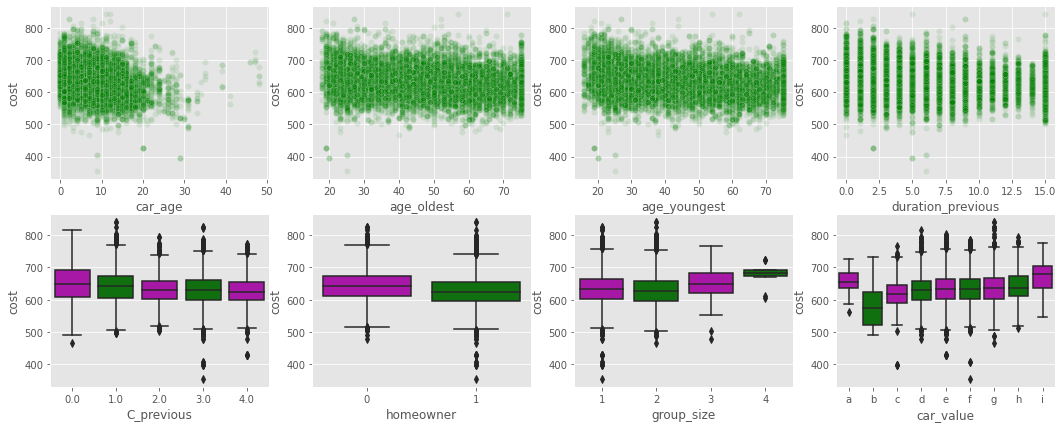

In [7]:
# Se dividen las variables en dos listas var_num y var_cat
var_num = ['car_age','age_oldest','age_youngest','duration_previous','C_previous','homeowner','group_size','car_value']
cat_num = ['A','B','C','D','E','F','G']

plt.figure(figsize=(18,7))

for i,var in enumerate(var_num):
    plt.subplot(2,4,i+1)
    if var in ['car_age','age_oldest','age_youngest','duration_previous']:
        sns.scatterplot(x=var,y='cost',data=df, alpha=0.10,color='g')
    else:
        sns.boxplot(x=var, y='cost', palette=["m", "g"], data=df)     


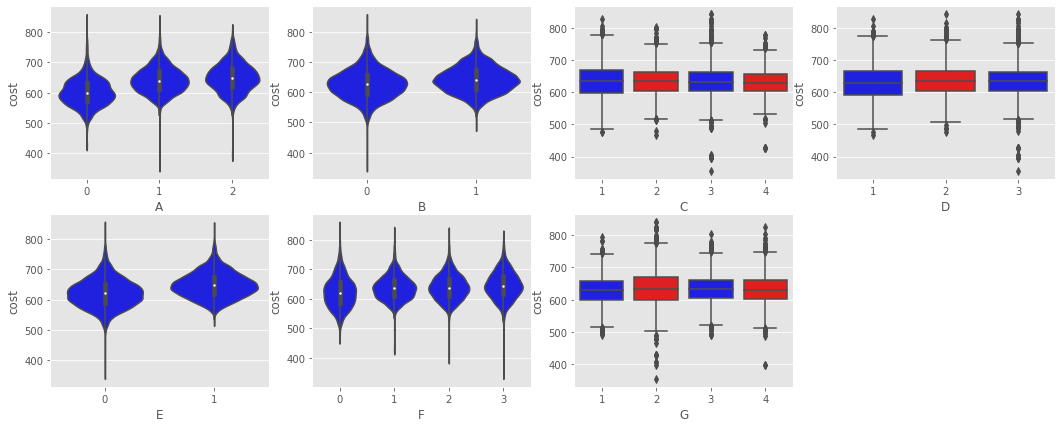

In [8]:
plt.figure(figsize=(18,7))

for j,cat in enumerate(cat_num):
    plt.subplot(2,4,j+1)
    if cat in ['A','B','E','F']:
        sns.violinplot(x=cat, y='cost', color="b", data=df)
    elif cat in ['C','D','G']:
        sns.boxplot(x=cat, y='cost', palette=["b", "r"], data=df)   

***After visualizing the numerical and categorical variables, it could be said that only some of them have a relationship with the cost of insurance, they are:C_previous,homeowner,group_size,car_value A(Collision),B (Towing) y E(Medical protection)***

<h3>Exercise 2 :</h3>
<p>Convert all categorical data to be in the one-hot encoding format.</p>

***Although in the data set there are variables defined as numerical, after the exploration it is observed that they are actually categorical, then all the categorical variables are expressed with one-hot encoding format.***

**Answer.**

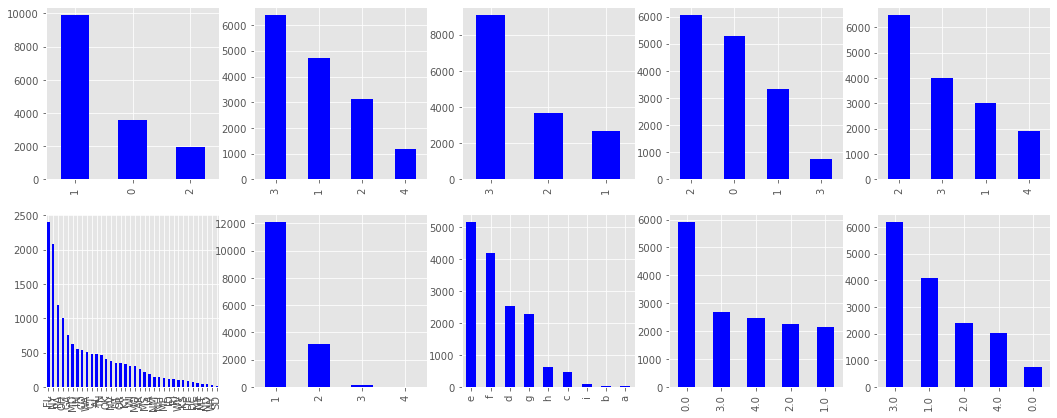

In [9]:
### Se listan todas las variables categoricas y las variables definidas como numericas que en realidad expresan una categoria.
### para esta labor se emplea la función get_dummies().
### se excluyen las columnas quee stan representadas con valores binarios 0-1 'B','E'.
var_cat = ['A','C','D','F','G','state','group_size','car_value','risk_factor','C_previous']


# visualizar la distribución de todas las variables, ya que despues de generar las variables ficticias y codificarlas
# en función de 0 y 1 se debe eliminar la información redundante que corresponde a la categoria de menor frecuencia.

plt.figure(figsize=(18,7))

for i, var in enumerate(var_cat):
    plt.subplot(2,5,i+1)
    df [var]. value_counts (). plot (kind = 'bar',color='b')
plt.show()

In [10]:
for var in var_cat:
    name_dummies= f'{var}_type_dummies'
    name_dummies = pd.get_dummies(df[var],prefix=var)
    print(pd.concat([df[var],name_dummies], axis=1).tail(n=10))
    
    frec = df[var].value_counts()
    name_index = (max(frec.index))
    
    name_dummies.drop(f'{var}_{name_index}',axis=1, inplace=True)
    print(name_dummies.head())
    print(len(name_dummies))
    
    df = pd.concat([df, name_dummies], axis=1)
    df.drop(f'{var}', axis=1, inplace=True)

df

       A  A_0  A_1  A_2
15473  1    0    1    0
15474  1    0    1    0
15475  1    0    1    0
15476  1    0    1    0
15477  1    0    1    0
15478  1    0    1    0
15479  1    0    1    0
15480  1    0    1    0
15481  2    0    0    1
15482  2    0    0    1
   A_0  A_1
0    1    0
1    0    0
2    0    0
3    0    0
4    0    1
15435
       C  C_1  C_2  C_3  C_4
15473  3    0    0    1    0
15474  3    0    0    1    0
15475  1    1    0    0    0
15476  1    1    0    0    0
15477  4    0    0    0    1
15478  4    0    0    0    1
15479  4    0    0    0    1
15480  4    0    0    0    1
15481  3    0    0    1    0
15482  3    0    0    1    0
   C_1  C_2  C_3
0    1    0    0
1    1    0    0
2    0    1    0
3    0    1    0
4    1    0    0
15435
       D  D_1  D_2  D_3
15473  3    0    0    1
15474  3    0    0    1
15475  2    0    1    0
15476  2    0    1    0
15477  3    0    0    1
15478  3    0    0    1
15479  3    0    0    1
15480  3    0    0    1
15481  3    0  

   car_value_a  car_value_b  car_value_c  car_value_d  car_value_e  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            1            0   

   car_value_f  car_value_g  car_value_h  
0            1            0            0  
1            1            0            0  
2            1            0            0  
3            1            0            0  
4            0            0            0  
15435
       risk_factor  risk_factor_0.0  risk_factor_1.0  risk_factor_2.0  \
15473          0.0                1                0                0   
15474          0.0                1                0                0   
15475          1.0                0                1                0   
15476          1.0     

,homeowner,car_age,age_oldest,age_youngest,married_couple,duration_previous,B,E,cost,A_0,A_1,C_1,C_2,C_3,D_1,D_2,F_0,F_1,F_2,G_1,G_2,G_3,state_AL,state_AR,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IN,state_KS,state_KY,state_MD,state_ME,state_MO,state_MS,state_MT,state_ND,state_NE,state_NH,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SD,state_TN,state_UT,state_WA,state_WI,state_WV,group_size_1,group_size_2,group_size_3,car_value_a,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,risk_factor_0.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,C_previous_0.0,C_previous_1.0,C_previous_2.0,C_previous_3.0
0,0,9,24,24,0,9.0,0,0,543,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,0,9,24,24,0,9.0,1,1,611,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
2,1,7,74,74,0,15.0,0,1,691,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,1,7,74,74,0,15.0,0,1,695,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,0,4,26,26,0,1.0,0,0,628,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,0,2,70,70,0,9.0,0,1,643,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15479,0,2,70,70,0,9.0,0,1,643,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15480,0,2,70,70,0,9.0,0,1,647,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15481,1,0,25,25,0,6.0,0,0,642,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


<h2>Fitting a multiple linear regression</h2>

<h3>Exercise 3 :</h3>
<p>Split your data into training and testing sets (an 80-20 split is a good starting point).</p>
<p><strong>Note:</strong> Keep random seed as 1337 in the code cell</p>

**Answer.**

In [11]:
# Se dividen los datos en conjunto de entrenamiento 80% y Test 20%, se fija una semilla para que los resultados sean reproducibles

X = df.drop('cost', axis = 1)
y = df[['cost']]
seed = 1337
test_data_size = 0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_data_size, random_state = seed)
train_data = pd.concat([X_train, y_train], axis = 1)
test_data = pd.concat([X_test, y_test], axis = 1)

In [12]:
#validar las dimensiones del conjunto de entrenamiento y test
print(X.shape)
print(y.shape)
print(train_data.shape)
print(test_data.shape)

(15435, 75)
(15435, 1)
(12348, 76)
(3087, 76)


In [13]:
train_data = train_data.rename (columns = {\
                     'C_previous_3.0': 'C_previous_3', \
                     'C_previous_2.0': 'C_previous_2', \
                     'C_previous_1.0': 'C_previous_1', \
                     'C_previous_0.0': 'C_previous_0', \
                     'risk_factor_3.0': 'risk_factor_3', \
                     'risk_factor_2.0': 'risk_factor_2', \
                     'risk_factor_1.0': 'risk_factor_1', \
                     'risk_factor_0.0': 'risk_factor_0'})

<h3>Exercise 4 :</h3>
<h4>4.1</h4>
<p>Fit a multiple linear regression model to the training data regressing cost against all the other variables. Call this <code>model_all</code>. What is the AIC value?</p>

**Answer.**

In [14]:
model_all = smf.ols ( formula = 'cost ~ homeowner + car_age + age_oldest + age_youngest+ married_couple+\
       duration_previous+ B + E + A_0+A_1+C_1+C_2+C_3+D_1+D_2+F_0+F_1+F_2+G_1+G_2+G_3+state_AL+state_AR+\
       state_CO+state_CT+state_DC+state_DE+state_FL+state_GA+state_IA+state_ID+state_IN+state_KS+state_KY+\
       state_MD+state_ME+state_MO+state_MS+state_MT+state_ND+state_NE+state_NH+state_NM+state_NV+state_NY+\
       state_OH+state_OK+state_OR+state_PA+state_RI+state_SD+state_TN+state_UT+state_WA+state_WI+state_WV+\
       group_size_1+group_size_2+group_size_3+car_value_a+car_value_b+car_value_c+car_value_d+car_value_e+\
       car_value_f+car_value_g+ car_value_h+risk_factor_0+risk_factor_1+risk_factor_2+risk_factor_3+\
       C_previous_0 + C_previous_1+C_previous_2+C_previous_3',\
       data = train_data ).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     154.1
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:59:46   Log-Likelihood:                -61015.
No. Observations:               12348   AIC:                         1.222e+05
Df Residuals:                   12272   BIC:                         1.227e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           721.3759     12.49

*** There are several model selection criteria that quantify the quality of a model by managing balance
between goodness of fit and simplicity. The most common is the AIC (Akaike Information Criterion).
The AIC penalizes the addition of more terms to a model THE AIC of the model is 1.222e + 05 whose value is very high,
which is due the large number of variables that resulted from the one-hot transformation of the categorical variables ***

<h4>4.2</h4>
<p>According to <code>model_all</code>, which states are most and least expensive?</p>

**Answer.**

The most expensive states are New York (NY) and Delawer (DE).  

The least expensive are Iowa (IA) and Wisconsin (WI)

<h4>4.3</h4>
<p>Interpret the coefficients of <code>group_size</code>, <code>homeowner</code>, <code>car_age</code>, <code>risk_factor</code>, <code>age_oldest</code>, <code>age_youngest</code>       <code>married_couple</code> , <code>duration_previous</code>. Do the signs and values of these coefficients make sense to you in the context of this business problem?</p>

**Answer.**

***All variables are statistically significant  
group_size: shows high weight and an inverse relationship to cost  
homeowner: shows high weight and an inverse relationship to cost  
car_age: shows high weights but with an inverse relationship in almost all its subcategories.  
risk_factor: shows high weights and some of its subcategories show a direct relationship with the cost.  
age_oldest: show low weight  
age_youngest: show low weight  
married_couple: shows low weight and inverse relationship  
duration_previous: shows low weight and inverse relationship  ***

<h3>Exercise 5 :</h3>
<p>Which variables from <code>model_all</code> are statistically significant? (For categorical variables, consider them to be significant if at least one of their categories are statistically significant). Refit the model using only these variables; call this <code>model_sig</code>. How does this model compare to the previous model?</p>

**Answer.**

In [44]:
# No son significativas para el modelo D: Daños a la propiedad (PD, niveles 1, 2, 3);B: Remolque (niveles: 0, 1)
# A pesar de mostrarse como estadisticamente significativas pero debido a que sus peso son muy bajos excluyo las variables
# age_oldest: edad de la persona de mayor edad en el grupo del cliente
# age_youngest: edad de la persona más joven del grupo del cliente
# car_age: Antiguedad del vehiculo

In [15]:
model_sig = smf.ols ( formula = 'cost ~ homeowner + married_couple+\
       duration_previous + E + A_0+A_1+C_1+C_2+C_3+F_0+F_1+F_2+G_1+G_2+G_3+state_AL+state_AR+\
       state_CO+state_CT+state_DC+state_DE+state_FL+state_GA+state_IA+state_ID+state_IN+state_KS+state_KY+\
       state_MD+state_ME+state_MO+state_MS+state_MT+state_ND+state_NE+state_NH+state_NM+state_NV+state_NY+\
       state_OH+state_OK+state_OR+state_PA+state_RI+state_SD+state_TN+state_UT+state_WA+state_WI+state_WV+\
       group_size_1+group_size_2+group_size_3+car_value_a+car_value_b+car_value_c+car_value_d+car_value_e+\
       car_value_f+car_value_g+ car_value_h+risk_factor_0+risk_factor_1+risk_factor_2+risk_factor_3+\
       C_previous_0 + C_previous_1+C_previous_2+C_previous_3',\
       data = train_data ).fit()
print(model_sig.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     155.7
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        17:59:58   Log-Likelihood:                -61231.
No. Observations:               12348   AIC:                         1.226e+05
Df Residuals:                   12278   BIC:                         1.231e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           747.6610     12.44

***By excluding the previous variables, it is observed that it decreases in a low explanatory percentage of the model from 48% to 46%, so validating the inclusion of the variables of less weight with some transformation can contribute to improve the model. The reduction of the AIC is not significant, so including new variables will not affect the model.***

<h3>Exercise 6 :</h3>
<p>In addition to the variables in <code>model_sig</code>, add terms for:</p>
<ol>
<li>square of <code>age_youngest</code></li>
<li>square term for the age of the car</li>
<li>interaction term for <code>car_value</code> and <code>age_youngest</code></li>
</ol>
<p>and save it to a new model <code>model_sig_plus</code>.</p>

**Answer.**

In [16]:
train_data['sqr_age_youngest']= train_data['age_youngest']**2
train_data['sqr_age_car']= train_data['car_age']**2
train_data['value_age_driv'] = (train_data['car_value_a']+train_data['car_value_b']+train_data['car_value_c']+train_data['car_value_d']+train_data['car_value_e']\
+train_data['car_value_f']+train_data['car_value_g']+train_data['car_value_h']) / train_data['sqr_age_youngest']
train_data

,homeowner,car_age,age_oldest,age_youngest,married_couple,duration_previous,B,E,A_0,A_1,C_1,C_2,C_3,D_1,D_2,F_0,F_1,F_2,G_1,G_2,G_3,state_AL,state_AR,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IN,state_KS,state_KY,state_MD,state_ME,state_MO,state_MS,state_MT,state_ND,state_NE,state_NH,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SD,state_TN,state_UT,state_WA,state_WI,state_WV,group_size_1,group_size_2,group_size_3,car_value_a,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,risk_factor_0,risk_factor_1,risk_factor_2,risk_factor_3,C_previous_0,C_previous_1,C_previous_2,C_previous_3,cost,sqr_age_youngest,sqr_age_car,value_age_driv
5039,1,10,70,68,1,15.0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,568,4624,100,0.000216
15101,1,5,60,60,0,15.0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,684,3600,25,0.000278
10255,1,13,56,56,0,9.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,582,3136,169,0.000319
1627,0,4,24,24,0,2.0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,628,576,16,0.001736
14186,0,22,43,18,0,15.0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,588,324,484,0.003086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,1,3,39,39,0,4.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,658,1521,9,0.000657
9481,1,11,75,75,0,15.0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,593,5625,121,0.000178
864,0,9,28,28,0,2.0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,654,784,81,0.001276
8413,1,7,30,30,0,1.0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,611,900,49,0.001111


In [17]:
model_sig_plus = smf.ols ( formula = 'cost ~ homeowner + married_couple+sqr_age_youngest+sqr_age_car+\
       duration_previous + E + A_0+A_1+C_1+C_2+C_3+F_0+F_1+F_2+G_1+G_2+G_3+state_AL+state_AR+value_age_driv+\
       state_CO+state_CT+state_DC+state_DE+state_FL+state_GA+state_IA+state_ID+state_IN+state_KS+state_KY+\
       state_MD+state_ME+state_MO+state_MS+state_MT+state_ND+state_NE+state_NH+state_NM+state_NV+state_NY+\
       state_OH+state_OK+state_OR+state_PA+state_RI+state_SD+state_TN+state_UT+state_WA+state_WI+state_WV+\
       group_size_1+group_size_2+group_size_3+car_value_a+car_value_b+car_value_c+car_value_d+car_value_e+\
       car_value_f+car_value_g+ car_value_h+risk_factor_0+risk_factor_1+risk_factor_2+risk_factor_3+\
       C_previous_0 + C_previous_1+C_previous_2+C_previous_3',\
       data = train_data ).fit()
print(model_sig_plus.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     172.8
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:00:47   Log-Likelihood:                -60790.
No. Observations:               12348   AIC:                         1.217e+05
Df Residuals:                   12275   BIC:                         1.223e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           710.8776     12.07

<h2>Feature selection</h2>

<p>To reduce the number of features, it can often be helpful to aggregate the categories; for example, we can create a new variable by assigning each state to a larger region:</p>

In [18]:
state_regions = pd.read_csv('https://raw.githubusercontent.com/cphalpert/census-regions/master/us%20census%20bureau%20regions%20and%20divisions.csv')
# should download the above file
#renombramos la columna State Code para eliminar el espacio
state_regions = state_regions.rename (columns = {'State Code': 'est_code'})
West = ['AK','WY','WA','AZ','CA','CO','UT','OR','NV','NM','MT','HI','ID']
South =['WV','AL','AR','VA','TX','TN','SC','DC','DE','FL','GA','OK','NC','MS','MD','LA','KY']
Northeast = ['VT','RI','PA','NY','NJ','NH','CT','ME','MA']
Midwest = ['WI','SD','OH','NE','ND','MO','MN','MI','KS','IN','IL','IA']
state_regions

,State,est_code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific
5,Colorado,CO,West,Mountain
6,Connecticut,CT,Northeast,New England
7,District of Columbia,DC,South,South Atlantic
8,Delaware,DE,South,South Atlantic
9,Florida,FL,South,South Atlantic


<h3>Exercise 7 :</h3>
<h4>7.1</h4>
<p>Create a new column where a state is replaced with the region it is in according to the above table.</p>

**Answer.**

In [19]:
#importo el dataframe orginal para agregar la columna "region" comando la region del dataframe state_regions

df_region = pd.read_csv('Allstate-cost-cleaned.csv',
    dtype = { # indicate categorical variables
        'A': 'category',
        'B': 'category',
        'C': 'category',
        'D': 'category',
        'E': 'category',
        'F': 'category',
        'G': 'category',
        'car_value': 'category',
        'state': 'category'
    }
)


In [20]:
# Se eliminan las columnas innecesarias y se eliminan nulos
df_region=df_region.drop(['Unnamed: 0'], axis=1)
df_region = df_region.dropna ()
print(df_region.shape)
df_region

(15435, 19)


,state,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,A,B,C,D,E,F,G,cost
0,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,0,0,1,1,0,0,4,543
1,OK,1,0,9,f,0.0,24,24,0,3.0,9.0,2,1,1,3,1,3,2,611
2,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,691
3,PA,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,695
4,AR,1,0,4,d,4.0,26,26,0,3.0,1.0,1,0,1,1,0,2,2,628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643
15479,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643
15480,FL,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,647
15481,NY,1,1,0,e,3.0,25,25,0,2.0,6.0,2,0,3,3,0,0,2,642


In [21]:
#Genero una funciòn que actualice el estado de acuerdo a la region
def region(estado):
    if estado in ['AK','WY','WA','AZ','CA','CO','UT','OR','NV','NM','MT','HI','ID']:
        return 'West'
    elif  estado in ['WV','AL','AR','VA','TX','TN','SC','DC','DE','FL','GA','OK','NC','MS','MD','LA','KY']:
        return 'South'
    elif  estado in ['VT','RI','PA','NY','NJ','NH','CT','ME','MA']:
        return 'Northeast'
    elif  estado in ['WI','SD','OH','NE','ND','MO','MN','MI','KS','IN','IL','IA']:
        return 'Midwest'

In [22]:
# Se crea la columna region y se elimina la columna estado
df_region['region']=df_region.state.apply(region)
df_region.drop('state', axis=1,inplace=True)
df_region

,group_size,homeowner,car_age,car_value,risk_factor,age_oldest,age_youngest,married_couple,C_previous,duration_previous,A,B,C,D,E,F,G,cost,region
0,1,0,9,f,0.0,24,24,0,3.0,9.0,0,0,1,1,0,0,4,543,South
1,1,0,9,f,0.0,24,24,0,3.0,9.0,2,1,1,3,1,3,2,611,South
2,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,691,Northeast
3,1,1,7,f,0.0,74,74,0,2.0,15.0,2,0,2,3,1,2,2,695,Northeast
4,1,0,4,d,4.0,26,26,0,3.0,1.0,1,0,1,1,0,2,2,628,South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643,South
15479,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,643,South
15480,1,0,2,g,1.0,70,70,0,4.0,9.0,1,0,4,3,1,2,3,647,South
15481,1,1,0,e,3.0,25,25,0,2.0,6.0,2,0,3,3,0,0,2,642,Northeast


In [23]:
#Procesamos las variables categoricas para el nuevo data set
var_cat2 = ['A','C','D','F','G','region','group_size','car_value','risk_factor','C_previous']
for var in var_cat2:
    name_dummies= f'{var}_type_dummies'
    name_dummies = pd.get_dummies(df_region[var],prefix=var)
    print(pd.concat([df_region[var],name_dummies], axis=1).tail(n=10))
    
    frec = df_region[var].value_counts()
    name_index = (max(frec.index))
    
    name_dummies.drop(f'{var}_{name_index}',axis=1, inplace=True)
    print(name_dummies.head())
    print(len(name_dummies))
    
    df_region = pd.concat([df_region, name_dummies], axis=1)
    df_region.drop(f'{var}', axis=1, inplace=True)

df_region

       A  A_0  A_1  A_2
15473  1    0    1    0
15474  1    0    1    0
15475  1    0    1    0
15476  1    0    1    0
15477  1    0    1    0
15478  1    0    1    0
15479  1    0    1    0
15480  1    0    1    0
15481  2    0    0    1
15482  2    0    0    1
   A_0  A_1
0    1    0
1    0    0
2    0    0
3    0    0
4    0    1
15435
       C  C_1  C_2  C_3  C_4
15473  3    0    0    1    0
15474  3    0    0    1    0
15475  1    1    0    0    0
15476  1    1    0    0    0
15477  4    0    0    0    1
15478  4    0    0    0    1
15479  4    0    0    0    1
15480  4    0    0    0    1
15481  3    0    0    1    0
15482  3    0    0    1    0
   C_1  C_2  C_3
0    1    0    0
1    1    0    0
2    0    1    0
3    0    1    0
4    1    0    0
15435
       D  D_1  D_2  D_3
15473  3    0    0    1
15474  3    0    0    1
15475  2    0    1    0
15476  2    0    1    0
15477  3    0    0    1
15478  3    0    0    1
15479  3    0    0    1
15480  3    0    0    1
15481  3    0  

,homeowner,car_age,age_oldest,age_youngest,married_couple,duration_previous,B,E,cost,A_0,A_1,C_1,C_2,C_3,D_1,D_2,F_0,F_1,F_2,G_1,G_2,G_3,region_Midwest,region_Northeast,region_South,group_size_1,group_size_2,group_size_3,car_value_a,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,risk_factor_0.0,risk_factor_1.0,risk_factor_2.0,risk_factor_3.0,C_previous_0.0,C_previous_1.0,C_previous_2.0,C_previous_3.0
0,0,9,24,24,0,9.0,0,0,543,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
1,0,9,24,24,0,9.0,1,1,611,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1
2,1,7,74,74,0,15.0,0,1,691,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
3,1,7,74,74,0,15.0,0,1,695,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
4,0,4,26,26,0,1.0,0,0,628,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,0,2,70,70,0,9.0,0,1,643,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15479,0,2,70,70,0,9.0,0,1,643,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15480,0,2,70,70,0,9.0,0,1,647,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
15481,1,0,25,25,0,6.0,0,0,642,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0


<h4>7.2</h4>
<p>Fit the model as in <code>model_sig_plus</code> but this time use <code>region</code> instead of <code>state</code>. Call this <code>model_region</code>.</p>

**Answer.**

In [33]:
# Se dividen los datos en conjunto de entrenamiento 80% y Test 20%, se fija una semilla para que los resultados sean reproducibles

X = df_region.drop('cost', axis = 1)
y = df_region[['cost']]
seed = 1337
test_data_size = 0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_data_size, random_state = seed)
train_data2 = pd.concat([X_train, y_train], axis = 1)
test_data2 = pd.concat([X_test, y_test], axis = 1)

#Se realizan todas las transformaciones antes de ajustar el nuevo modelo

train_data2 = train_data2.rename (columns = {\
                     'C_previous_3.0': 'C_previous_3', \
                     'C_previous_2.0': 'C_previous_2', \
                     'C_previous_1.0': 'C_previous_1', \
                     'C_previous_0.0': 'C_previous_0', \
                     'risk_factor_3.0': 'risk_factor_3', \
                     'risk_factor_2.0': 'risk_factor_2', \
                     'risk_factor_1.0': 'risk_factor_1', \
                     'risk_factor_0.0': 'risk_factor_0'})

train_data2['sqr_age_youngest']= train_data2['age_youngest']**2
train_data2['sqr_age_car']= train_data2['car_age']**2
train_data2['value_age_driv'] = (train_data2['car_value_a']+train_data2['car_value_b']+train_data2['car_value_c']+train_data2['car_value_d']+train_data2['car_value_e']\
+train_data2['car_value_f']+train_data2['car_value_g']+train_data2['car_value_h']) / train_data2['sqr_age_youngest']
train_data2


,homeowner,car_age,age_oldest,age_youngest,married_couple,duration_previous,B,E,A_0,A_1,C_1,C_2,C_3,D_1,D_2,F_0,F_1,F_2,G_1,G_2,G_3,region_Midwest,region_Northeast,region_South,group_size_1,group_size_2,group_size_3,car_value_a,car_value_b,car_value_c,car_value_d,car_value_e,car_value_f,car_value_g,car_value_h,risk_factor_0,risk_factor_1,risk_factor_2,risk_factor_3,C_previous_0,C_previous_1,C_previous_2,C_previous_3,cost,sqr_age_youngest,sqr_age_car,value_age_driv
5039,1,10,70,68,1,15.0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,568,4624,100,0.000216
15101,1,5,60,60,0,15.0,1,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,684,3600,25,0.000278
10255,1,13,56,56,0,9.0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,582,3136,169,0.000319
1627,0,4,24,24,0,2.0,1,1,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,628,576,16,0.001736
14186,0,22,43,18,0,15.0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,588,324,484,0.003086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,1,3,39,39,0,4.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,658,1521,9,0.000657
9481,1,11,75,75,0,15.0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,593,5625,121,0.000178
864,0,9,28,28,0,2.0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,654,784,81,0.001276
8413,1,7,30,30,0,1.0,1,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,611,900,49,0.001111


In [34]:
model_region = smf.ols ( formula = 'cost ~ homeowner + married_couple+sqr_age_youngest+sqr_age_car+\
       duration_previous + E + A_0+A_1+C_1+C_2+C_3+F_0+F_1+F_2+G_1+G_2+G_3+value_age_driv+ region_Midwest+\
       region_Northeast+region_South+ group_size_1+group_size_2+group_size_3+car_value_a+car_value_b+\
       car_value_c+car_value_d+car_value_e+ car_value_f+car_value_g+ car_value_h+risk_factor_0+risk_factor_1+\
       risk_factor_2+risk_factor_3+ C_previous_0 + C_previous_1+C_previous_2+C_previous_3',\
       data = train_data2 ).fit()
print(model_region.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     201.6
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:09:57   Log-Likelihood:                -62000.
No. Observations:               12348   AIC:                         1.241e+05
Df Residuals:                   12307   BIC:                         1.244e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           722.0176     11.53

<h3>Exercise 8 :</h3>
<h4>8.1</h4>
<p>What should we do next to minimize features?</p>

**Answer.**

***To determine the variables with the greatest influence on the dependent variable, correlation matrices or a correlation graph can be used.***

<h4>8.2</h4>
<p>Using a method of your choice, find the numerical feature(s) in <code>model_region</code>, except for the three we added in Exercise 6, which exhibit multicollinearity. <strong>Hint:</strong> consider looking at correlations.</p>

**Answer.**

In [38]:
### Para determinar las correlaciones
corr_matriz  = train_data[['cost','homeowner','car_age','age_oldest','age_youngest','married_couple','duration_previous','B','E','A_0','A_1']].corr()
corr_matriz

,cost,homeowner,car_age,age_oldest,age_youngest,married_couple,duration_previous,A_0,A_1
cost,1.000000,-0.189605,-0.265554,-0.166106,-0.200448,-0.060956,-0.153835,-0.372306,0.239427
homeowner,-0.189605,1.000000,-0.050924,0.398684,0.346405,0.191089,0.178462,-0.073521,0.080690
car_age,-0.265554,-0.050924,1.000000,-0.026708,-0.027993,-0.037670,-0.059357,0.442371,-0.306841
age_oldest,-0.166106,0.398684,-0.026708,1.000000,0.915816,0.208240,0.275573,-0.075891,0.093757
age_youngest,-0.200448,0.346405,-0.027993,0.915816,1.000000,0.102905,0.247794,-0.077415,0.097697
married_couple,-0.060956,0.191089,-0.037670,0.208240,0.102905,1.000000,0.072806,-0.020959,0.016967
duration_previous,-0.153835,0.178462,-0.059357,0.275573,0.247794,0.072806,1.000000,-0.118694,0.125771
A_0,-0.372306,-0.073521,0.442371,-0.075891,-0.077415,-0.020959,-0.118694,1.000000,-0.734044
A_1,0.239427,0.080690,-0.306841,0.093757,0.097697,0.016967,0.125771,-0.734044,1.000000


Text(0.5, 1.0, 'Matriz de correlación')

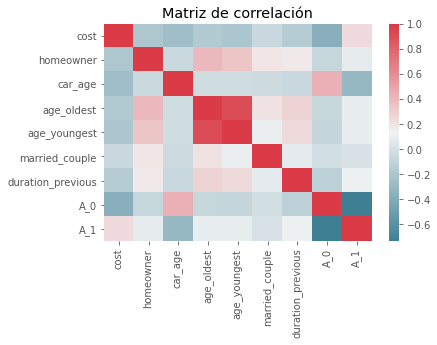

In [39]:
# Se puede validar las correlaciones en un mapa de calor
sns.heatmap(corr_matriz,cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Matriz de correlación")

In [ ]:
# Se observa que hay una alta correlacion entre las variables age_oldest y age_yungest, por lo anto no es produente eliminar
# ninguna de estas dos variables, las otras variables otras variables independiente se podrian omitir ya que es aconsejable 
# que tengan un coeficiente de correlación de 0,4 o más con la variable dependiente.

<h4>8.3:</h4>
<p>Refit <code>model_region</code> after dropping these redundant predictor(s); call this <code>model_region_no_oldest</code>.</p>

**Answer.**

In [79]:
#Modelo sin predictore redundantes

train_data3 = train_data2[['cost','age_oldest','age_youngest','A_0','A_1','group_size_1','group_size_2','group_size_3',\
                           'region_Northeast','region_South','region_Midwest','G_1','G_2','G_3','risk_factor_0',\
                           'risk_factor_1','risk_factor_2','risk_factor_3','car_value_a','car_value_b','car_value_c',\
                           'car_value_d','car_value_e','car_value_f','car_value_g','car_value_h','C_previous_0',\
                           'C_previous_1','C_previous_2','C_previous_3','C_1','C_2','C_3','F_0','F_1','F_2']]
                        

model_region_no_oldest = smf.ols ( formula = 'cost ~ age_oldest + age_youngest + A_0 + A_1 +group_size_1+group_size_2+\
                        group_size_3+ region_Northeast+ region_South+ region_Midwest+G_1+G_2+G_3+risk_factor_0+\
                        risk_factor_1+risk_factor_2+risk_factor_3+car_value_a+car_value_b+car_value_c+car_value_d+\
                        car_value_e+ car_value_f+car_value_g+ car_value_h+C_previous_0+C_previous_1+C_previous_2+\
                        C_previous_3+C_1+C_2+C_3+F_0+F_1+F_2',data = train_data3 ).fit()
print(model_region_no_oldest.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.328
Method:                 Least Squares   F-statistic:                     172.8
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        20:41:04   Log-Likelihood:                -62643.
No. Observations:               12348   AIC:                         1.254e+05
Df Residuals:                   12312   BIC:                         1.256e+05
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          714.5300     12.123  

<h4>8.4</h4>
<p>What would you do to diagnose the <code>model_region_no_oldest</code> fit? What does this diagnosis suggest to you? (Hint: try plotting the residuals in various ways.)</p>

**Answer.**

In [82]:
#Obtenemos los residuos, debe retornat True si es correcto el proceso
resid = train_data3.cost - model_region_no_oldest.fittedvalues
np.allclose(resid, model_region_no_oldest.resid)

True

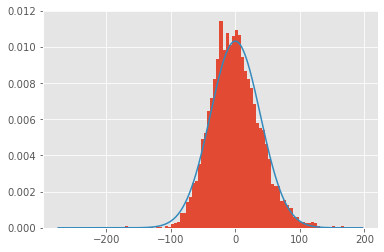

In [87]:
plt.hist(model_region_no_oldest.resid, density=True, bins=100, label="residuos")              

xx = np.linspace(model_region_no_oldest.resid.min(), model_region_no_oldest.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_region_no_oldest.scale)),
    label="normal distribution")
plt.show()

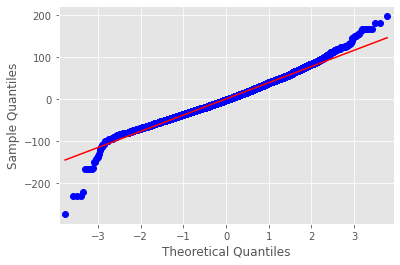

In [83]:
sm.qqplot(model_region_no_oldest.resid, line="s");

In [ ]:
#Al observar los graficos de residuos y QQ se observa que el modelo ajusta bastante bien la mayoria de los datos
#pero no explica de manera satisfactoria los valores extremos ppor lo que se sugiere que existen variable con que
#se expresarian mejor a traves de relaciones no lineales.

<h3>Exercise 9 :</h3>
<h4>9.1</h4>
<p>Find the best Box-Cox transformation of <code>cost</code> used to fit <code>model_region_no_oldest</code>. What value do you get?</p>

**Answer.**

In [100]:
model_region_no_oldest = smf.ols ( formula = 'np.log(cost) ~ np.log(age_oldest) + np.log(age_youngest) +A_0 + A_1 +group_size_1+group_size_2+\
                        group_size_3+ region_Northeast+ region_South+ region_Midwest+G_1+G_2+G_3+risk_factor_0+\
                        risk_factor_1+risk_factor_2+risk_factor_3+car_value_a+car_value_b+car_value_c+car_value_d+\
                        car_value_e+ car_value_f+car_value_g+ car_value_h+C_previous_0+C_previous_1+C_previous_2+\
                        C_previous_3+C_1+C_2+C_3+F_0+F_1+F_2',data = train_data3 ).fit()
print(model_region_no_oldest.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(cost)   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     181.7
Date:                Thu, 08 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:33:46   Log-Likelihood:                 17070.
No. Observations:               12348   AIC:                        -3.407e+04
Df Residuals:                   12312   BIC:                        -3.380e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6688 

<p>They both look okay, though the square root transformation looks slightly better visually.</p>

<h4>9.2</h4>
<p>Refit <code>model_region_no_oldest</code>, but now with the transformation as suggested by the Box-Cox. Call it <code>model_region_no_oldest_box_cox</code>.</p>

**Answer.**

-------

<h2>Conclusion</h2>
<p>In this, you practiced creating linear models using <code>statsmodels</code> and iteratively trimming the input variables to go from including all the variables in the dataset to using only the most relevant variables. You excluded those variables that were statistically insignificant and removed those that had high correlation. Finally, we performed some feature engineering in an attempt to remove some tail behavior that deviates from the normal distribution to better fit our linear model. In the end, we had a very minimal model that contained variables that other insurance companies use to charge premiums that gave us insight on how we can better serve a niche population. </p>